In [94]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
import scipy
import numpy as np
import pandas as pd
import copy
import statsmodels.api as sm

In [95]:
!PYTORCH_ENABLE_MPS_FALLBACK=1

In [96]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),
                              ])

train_dataset = datasets.MNIST('./mnist/MNIST_data/', download=True, train=True, transform=transform)
test_dataset = datasets.MNIST('./mnist/MNIST_data/', download=True, train=False, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [97]:
def crossent_loss(y_hat, y):
    # y_hat has shape (N, 10) for 10 classes, y has shape (N,)
    f = torch.nn.CrossEntropyLoss(reduction='sum')
    return f(y_hat, y)

In [98]:
def probabilties_from_scores(y):
    f = torch.nn.Softmax(dim=1)
    p = f(y)
    return p

In [99]:
def dense_beta_loss(evidential_output, target):
    alphas, betas = evidential_output
    # return loss(alphas/(alphas+betas), target)
    true_alphas = alphas.gather(1,target.view(-1,1))
    true_betas = betas.gather(1,target.view(-1,1))
    return torch.digamma(alphas+betas).sum() - torch.digamma(betas).sum()+torch.digamma(true_betas).sum()-torch.digamma(true_alphas).sum()

def tabular_inspired_loss(evidential_output, target):
    alphas, betas = evidential_output
    true_alphas = alphas.gather(1,target.view(-1,1))
    true_betas = betas.gather(1,target.view(-1,1))
    return -(true_alphas.sum() +betas.sum() - true_betas.sum()) + crossent_loss(torch.nn.functional.normalize(alphas,1), target)

def dirichlet_kl_div(alphas, target):
    return torch.lgamma(target.sum(axis=1)) - torch.lgamma(alphas.sum(axis=1)) + torch.lgamma(alphas).sum(axis=1) - torch.lgamma(target).sum(axis=1) + ((target-alphas)*(torch.digamma(target)-torch.digamma(target.sum(axis=1).view(-1,1)))).sum(axis=1)

def dirichlet_loss(alphas, target, regularizer = True):
    true_alphas = alphas.gather(1,target.view(-1,1))
    loss = torch.digamma(alphas.sum(axis=1)).sum() - torch.digamma(true_alphas).sum()
    if regularizer:
        x = torch.ones_like(alphas)*.1
        x[target] = true_alphas
        loss += 0*dirichlet_kl_div(alphas, x).sum()
    return loss

In [100]:
def evaluate(dataloader, model, device, log=False, regularizer = True):
    correct_count, total_count = 0, 0
    loss = 0
    cross_loss = 0
    for images_batch, labels_batch in dataloader:
        images = images_batch.reshape(images_batch.shape[0], 28*28)
        alphas, betas = model(images.to(device))
        probabilities = alphas/(alphas+betas)
        # alphas = model(images.to(device))
        # print(alphas.shape)
        # probabilities = torch.nn.functional.normalize(alphas,1)
        # probabilities = probabilties_from_scores(scores)
        loss += dense_beta_loss((alphas,betas),labels_batch)
        # loss += dirichlet_loss(alphas, labels_batch, regularizer = regularizer)
        # cross_loss += -torch.log(probabilities.gather(1,labels_batch.view(-1,1))).sum()
        pred_label = probabilities.max(1, keepdim=True)[1]
        correct_count += pred_label.eq(labels_batch.to(device).view_as(pred_label)).sum().item()
        total_count += labels_batch.shape[0]

    if log:
        print("Number Of Images Tested =", total_count)
        print("Model Accuracy =", (correct_count/total_count))

    return correct_count/total_count, loss

In [101]:
class Net(torch.nn.Module):
    def __init__(self, layer_sizes, inference_type='regression'):
        super(Net, self).__init__()
        self.layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-2)])
        self.output_layer = torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
        self.inference_type = inference_type

    def forward(self, x):
        # x = self.input_instance_norm(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = torch.nn.functional.hardtanh_(x) + x
        x = self.output_layer(x)
        if self.inference_type == 'classification':
            x = torch.nn.functional.softmax(x,dim=-1)
        return x

class EvidentialDenseBetaNet(torch.nn.Module):
    def __init__(self, layer_sizes, inference_type='classification'):
        super(EvidentialDenseBetaNet, self).__init__()
        self.layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-2)])
        self.output_alpha_layer = torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
        self.output_beta_layer = torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
        self.inference_type = inference_type
        torch.nn.init.zeros_(self.output_alpha_layer.weight)
        torch.nn.init.zeros_(self.output_beta_layer.weight)
        self.output_alpha_layer.bias.data.fill_(np.log(.5))
        self.output_beta_layer.bias.data.fill_(np.log(.5))
        # self.output_alpha_layer.bias.data.fill_(.5)
        # self.output_beta_layer.bias.data.fill_(.5)

    def forward(self, x):
        # x = self.input_instance_norm(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = torch.nn.functional.hardtanh_(x) + x
        alphas = torch.exp(self.output_alpha_layer(x))
        betas = torch.exp(self.output_beta_layer(x))
        # alphas = self.output_alpha_layer(x)
        # betas = self.output_beta_layer(x)
        return alphas, betas

class EvidentialDirichletNet(torch.nn.Module):
    def __init__(self, layer_sizes, inference_type='classification'):
        super(EvidentialDirichletNet, self).__init__()
        self.layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-2)])
        self.output_alpha_layer = torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
        self.output_beta_layer = torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
        self.inference_type = inference_type
        torch.nn.init.zeros_(self.output_alpha_layer.weight)
        self.output_alpha_layer.bias.data.fill_(np.log(.5))

    def forward(self, x):
        # x = self.input_instance_norm(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = torch.nn.functional.hardtanh_(x) + x
        alphas = torch.exp(self.output_alpha_layer(x))
        return alphas

In [102]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else "cpu"))
device='cpu'

In [103]:
# model = general_models.FFNetwork([784, 100, 10], 'classification').to(device)
model = EvidentialDenseBetaNet([784, 200, 100, 10], 'classification').to(device)
# model = EvidentialDirichletNet([784, 200, 200, 100, 10], 'classification').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-8)

In [104]:
epochs = 100
best_loss = float('inf')
for epoch in range(epochs):
    running_loss = 0

    for images_batch, labels_batch in tqdm(train_dataloader):
        images_batch = images_batch.reshape(images_batch.shape[0], 28*28)   # Flatten MNIST images into a 784 long vector

        # forward pass
        y_hat = model(images_batch.to(device))
        y = labels_batch.to(device)
        L = dense_beta_loss(y_hat, y)
        # L = tabular_inspired_loss(y_hat, y)
        # L = dirichlet_loss(y_hat, y)

        # backward pass
        optimizer.zero_grad()
        L.backward()

        # update parameters
        optimizer.step()

        running_loss += L.item()

    training_loss = running_loss/len(train_dataloader)
    train_accuracy, _ = evaluate(train_dataloader, model, device)
    test_accuracy, test_loss = evaluate(test_dataloader, model, device, regularizer = False)
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = copy.deepcopy(model)

    if epoch % 1 == 0:
        print("Epoch {} - Training loss: {}  Training Accuracy: {}  Test Accuracy: {}  Test Loss: {}".format(epoch, training_loss, round(train_accuracy,4), test_accuracy, test_loss))

    # if test_accuracy > .98:
    #     break

100%|██████████| 59/59 [00:02<00:00, 21.55it/s]


Epoch 0 - Training loss: 14097.608050847457  Training Accuracy: 0.5646  Test Accuracy: 0.577  Test Loss: 138623.21875


100%|██████████| 59/59 [00:02<00:00, 19.75it/s]


Epoch 1 - Training loss: 14096.989936440677  Training Accuracy: 0.5653  Test Accuracy: 0.5766  Test Loss: 138617.0625


100%|██████████| 59/59 [00:02<00:00, 24.60it/s]


Epoch 2 - Training loss: 14096.37202065678  Training Accuracy: 0.5669  Test Accuracy: 0.5786  Test Loss: 138610.8125


100%|██████████| 59/59 [00:02<00:00, 23.44it/s]


Epoch 3 - Training loss: 14095.749983448093  Training Accuracy: 0.5671  Test Accuracy: 0.5797  Test Loss: 138604.59375


100%|██████████| 59/59 [00:02<00:00, 24.52it/s]


Epoch 4 - Training loss: 14095.125728283898  Training Accuracy: 0.5668  Test Accuracy: 0.5796  Test Loss: 138598.328125


100%|██████████| 59/59 [00:02<00:00, 24.33it/s]


Epoch 5 - Training loss: 14094.49865929555  Training Accuracy: 0.5669  Test Accuracy: 0.5783  Test Loss: 138592.0


100%|██████████| 59/59 [00:02<00:00, 22.34it/s]


Epoch 6 - Training loss: 14093.86904131356  Training Accuracy: 0.5662  Test Accuracy: 0.5785  Test Loss: 138585.6875


100%|██████████| 59/59 [00:02<00:00, 25.42it/s]


Epoch 7 - Training loss: 14093.23664261123  Training Accuracy: 0.566  Test Accuracy: 0.5781  Test Loss: 138579.34375


100%|██████████| 59/59 [00:02<00:00, 25.59it/s]


Epoch 8 - Training loss: 14092.601645259534  Training Accuracy: 0.5653  Test Accuracy: 0.578  Test Loss: 138572.96875


100%|██████████| 59/59 [00:02<00:00, 24.52it/s]


Epoch 9 - Training loss: 14091.96418167373  Training Accuracy: 0.5651  Test Accuracy: 0.5773  Test Loss: 138566.546875


100%|██████████| 59/59 [00:02<00:00, 23.32it/s]


Epoch 10 - Training loss: 14091.324599443857  Training Accuracy: 0.5651  Test Accuracy: 0.5775  Test Loss: 138560.140625


100%|██████████| 59/59 [00:02<00:00, 24.76it/s]


Epoch 11 - Training loss: 14090.682501324152  Training Accuracy: 0.5642  Test Accuracy: 0.5759  Test Loss: 138553.6875


100%|██████████| 59/59 [00:02<00:00, 25.49it/s]


Epoch 12 - Training loss: 14090.037837658898  Training Accuracy: 0.5639  Test Accuracy: 0.5765  Test Loss: 138547.203125


100%|██████████| 59/59 [00:02<00:00, 25.54it/s]


Epoch 13 - Training loss: 14089.39108845339  Training Accuracy: 0.5633  Test Accuracy: 0.5757  Test Loss: 138540.703125


100%|██████████| 59/59 [00:02<00:00, 22.08it/s]


Epoch 14 - Training loss: 14088.7421875  Training Accuracy: 0.563  Test Accuracy: 0.5747  Test Loss: 138534.1875


100%|██████████| 59/59 [00:02<00:00, 24.45it/s]


Epoch 15 - Training loss: 14088.090340307202  Training Accuracy: 0.5626  Test Accuracy: 0.5742  Test Loss: 138527.625


100%|██████████| 59/59 [00:02<00:00, 21.37it/s]


Epoch 16 - Training loss: 14087.436854475636  Training Accuracy: 0.5621  Test Accuracy: 0.5741  Test Loss: 138521.09375


100%|██████████| 59/59 [00:02<00:00, 22.45it/s]


Epoch 17 - Training loss: 14086.780538268009  Training Accuracy: 0.5617  Test Accuracy: 0.5735  Test Loss: 138514.484375


100%|██████████| 59/59 [00:02<00:00, 23.21it/s]


Epoch 18 - Training loss: 14086.122517213984  Training Accuracy: 0.5611  Test Accuracy: 0.573  Test Loss: 138507.875


100%|██████████| 59/59 [00:02<00:00, 22.85it/s]


Epoch 19 - Training loss: 14085.461665783898  Training Accuracy: 0.5607  Test Accuracy: 0.5732  Test Loss: 138501.265625


100%|██████████| 59/59 [00:02<00:00, 24.37it/s]


Epoch 20 - Training loss: 14084.79949020127  Training Accuracy: 0.5603  Test Accuracy: 0.573  Test Loss: 138494.609375


100%|██████████| 59/59 [00:02<00:00, 23.99it/s]


Epoch 21 - Training loss: 14084.134318723516  Training Accuracy: 0.5597  Test Accuracy: 0.5729  Test Loss: 138487.9375


100%|██████████| 59/59 [00:02<00:00, 22.97it/s]


Epoch 22 - Training loss: 14083.467276880298  Training Accuracy: 0.5591  Test Accuracy: 0.5727  Test Loss: 138481.234375


100%|██████████| 59/59 [00:02<00:00, 24.67it/s]


Epoch 23 - Training loss: 14082.79790121822  Training Accuracy: 0.5587  Test Accuracy: 0.572  Test Loss: 138474.5


100%|██████████| 59/59 [00:02<00:00, 23.30it/s]


Epoch 24 - Training loss: 14082.126241393009  Training Accuracy: 0.5583  Test Accuracy: 0.5709  Test Loss: 138467.765625


100%|██████████| 59/59 [00:02<00:00, 24.44it/s]


Epoch 25 - Training loss: 14081.452744306143  Training Accuracy: 0.5578  Test Accuracy: 0.5711  Test Loss: 138460.984375


100%|██████████| 59/59 [00:02<00:00, 25.29it/s]


Epoch 26 - Training loss: 14080.77626787606  Training Accuracy: 0.5573  Test Accuracy: 0.5706  Test Loss: 138454.203125


100%|██████████| 59/59 [00:02<00:00, 24.90it/s]


Epoch 27 - Training loss: 14080.098351430084  Training Accuracy: 0.5568  Test Accuracy: 0.57  Test Loss: 138447.40625


100%|██████████| 59/59 [00:02<00:00, 22.07it/s]


Epoch 28 - Training loss: 14079.418250132416  Training Accuracy: 0.5567  Test Accuracy: 0.5704  Test Loss: 138440.578125


100%|██████████| 59/59 [00:02<00:00, 21.29it/s]


Epoch 29 - Training loss: 14078.735897775423  Training Accuracy: 0.5562  Test Accuracy: 0.5697  Test Loss: 138433.71875


100%|██████████| 59/59 [00:02<00:00, 24.06it/s]


Epoch 30 - Training loss: 14078.051873675848  Training Accuracy: 0.5557  Test Accuracy: 0.5686  Test Loss: 138426.875


100%|██████████| 59/59 [00:02<00:00, 22.64it/s]


Epoch 31 - Training loss: 14077.365499205509  Training Accuracy: 0.5554  Test Accuracy: 0.5685  Test Loss: 138420.0


100%|██████████| 59/59 [00:02<00:00, 24.39it/s]


Epoch 32 - Training loss: 14076.677138506357  Training Accuracy: 0.555  Test Accuracy: 0.5675  Test Loss: 138413.0625


100%|██████████| 59/59 [00:02<00:00, 21.09it/s]


Epoch 33 - Training loss: 14075.986626059323  Training Accuracy: 0.5544  Test Accuracy: 0.5668  Test Loss: 138406.140625


100%|██████████| 59/59 [00:02<00:00, 24.20it/s]


Epoch 34 - Training loss: 14075.294177039195  Training Accuracy: 0.5541  Test Accuracy: 0.567  Test Loss: 138399.1875


100%|██████████| 59/59 [00:02<00:00, 24.79it/s]


Epoch 35 - Training loss: 14074.59997351695  Training Accuracy: 0.5537  Test Accuracy: 0.5669  Test Loss: 138392.234375


100%|██████████| 59/59 [00:02<00:00, 24.54it/s]


Epoch 36 - Training loss: 14073.90434653072  Training Accuracy: 0.5535  Test Accuracy: 0.5664  Test Loss: 138385.25


100%|██████████| 59/59 [00:02<00:00, 25.04it/s]


Epoch 37 - Training loss: 14073.206501588984  Training Accuracy: 0.5533  Test Accuracy: 0.5657  Test Loss: 138378.25


100%|██████████| 59/59 [00:02<00:00, 24.84it/s]


Epoch 38 - Training loss: 14072.506869041314  Training Accuracy: 0.5528  Test Accuracy: 0.5656  Test Loss: 138371.21875


100%|██████████| 59/59 [00:02<00:00, 24.79it/s]


Epoch 39 - Training loss: 14071.80561440678  Training Accuracy: 0.5522  Test Accuracy: 0.5653  Test Loss: 138364.203125


100%|██████████| 59/59 [00:02<00:00, 24.81it/s]


Epoch 40 - Training loss: 14071.102737685382  Training Accuracy: 0.5519  Test Accuracy: 0.5652  Test Loss: 138357.140625


100%|██████████| 59/59 [00:02<00:00, 23.81it/s]


Epoch 41 - Training loss: 14070.397626456568  Training Accuracy: 0.5514  Test Accuracy: 0.5646  Test Loss: 138350.0625


100%|██████████| 59/59 [00:02<00:00, 24.48it/s]


Epoch 42 - Training loss: 14069.691273834746  Training Accuracy: 0.5513  Test Accuracy: 0.5646  Test Loss: 138342.96875


100%|██████████| 59/59 [00:02<00:00, 24.21it/s]


Epoch 43 - Training loss: 14068.982587394068  Training Accuracy: 0.551  Test Accuracy: 0.5641  Test Loss: 138335.890625


100%|██████████| 59/59 [00:02<00:00, 24.46it/s]


Epoch 44 - Training loss: 14068.272311970339  Training Accuracy: 0.5505  Test Accuracy: 0.5633  Test Loss: 138328.78125


100%|██████████| 59/59 [00:02<00:00, 22.97it/s]


Epoch 45 - Training loss: 14067.560282044491  Training Accuracy: 0.5503  Test Accuracy: 0.563  Test Loss: 138321.578125


100%|██████████| 59/59 [00:02<00:00, 23.99it/s]


Epoch 46 - Training loss: 14066.846464512711  Training Accuracy: 0.5497  Test Accuracy: 0.5629  Test Loss: 138314.4375


100%|██████████| 59/59 [00:02<00:00, 24.17it/s]


Epoch 47 - Training loss: 14066.130991790254  Training Accuracy: 0.5494  Test Accuracy: 0.5619  Test Loss: 138307.28125


100%|██████████| 59/59 [00:02<00:00, 23.84it/s]


Epoch 48 - Training loss: 14065.41396318856  Training Accuracy: 0.5492  Test Accuracy: 0.5619  Test Loss: 138300.0625


100%|██████████| 59/59 [00:02<00:00, 23.89it/s]


Epoch 49 - Training loss: 14064.695113877118  Training Accuracy: 0.5489  Test Accuracy: 0.5616  Test Loss: 138292.84375


100%|██████████| 59/59 [00:02<00:00, 24.70it/s]


Epoch 50 - Training loss: 14063.974394200211  Training Accuracy: 0.5486  Test Accuracy: 0.561  Test Loss: 138285.625


100%|██████████| 59/59 [00:02<00:00, 24.04it/s]


Epoch 51 - Training loss: 14063.251837261652  Training Accuracy: 0.5482  Test Accuracy: 0.5608  Test Loss: 138278.390625


100%|██████████| 59/59 [00:02<00:00, 24.47it/s]


Epoch 52 - Training loss: 14062.527923066737  Training Accuracy: 0.5477  Test Accuracy: 0.5601  Test Loss: 138271.125


100%|██████████| 59/59 [00:02<00:00, 24.02it/s]


Epoch 53 - Training loss: 14061.802055746823  Training Accuracy: 0.5477  Test Accuracy: 0.5598  Test Loss: 138263.84375


100%|██████████| 59/59 [00:02<00:00, 24.10it/s]


Epoch 54 - Training loss: 14061.075079449152  Training Accuracy: 0.5474  Test Accuracy: 0.5592  Test Loss: 138256.5625


100%|██████████| 59/59 [00:02<00:00, 22.38it/s]


Epoch 55 - Training loss: 14060.346414856991  Training Accuracy: 0.5469  Test Accuracy: 0.559  Test Loss: 138249.234375


100%|██████████| 59/59 [00:02<00:00, 24.13it/s]


Epoch 56 - Training loss: 14059.616128177966  Training Accuracy: 0.5467  Test Accuracy: 0.559  Test Loss: 138241.921875


100%|██████████| 59/59 [00:02<00:00, 23.93it/s]


Epoch 57 - Training loss: 14058.884070444916  Training Accuracy: 0.5462  Test Accuracy: 0.5586  Test Loss: 138234.5625


100%|██████████| 59/59 [00:02<00:00, 24.98it/s]


Epoch 58 - Training loss: 14058.150969941737  Training Accuracy: 0.5461  Test Accuracy: 0.5585  Test Loss: 138227.203125


100%|██████████| 59/59 [00:02<00:00, 23.73it/s]


Epoch 59 - Training loss: 14057.415899761652  Training Accuracy: 0.5458  Test Accuracy: 0.5585  Test Loss: 138219.859375


100%|██████████| 59/59 [00:02<00:00, 23.59it/s]


Epoch 60 - Training loss: 14056.679571636652  Training Accuracy: 0.5454  Test Accuracy: 0.558  Test Loss: 138212.484375


100%|██████████| 59/59 [00:02<00:00, 23.35it/s]


Epoch 61 - Training loss: 14055.94172073623  Training Accuracy: 0.545  Test Accuracy: 0.5575  Test Loss: 138205.0625


100%|██████████| 59/59 [00:02<00:00, 22.90it/s]


Epoch 62 - Training loss: 14055.202164989407  Training Accuracy: 0.5447  Test Accuracy: 0.5572  Test Loss: 138197.671875


100%|██████████| 59/59 [00:02<00:00, 24.69it/s]


Epoch 63 - Training loss: 14054.460805084746  Training Accuracy: 0.5443  Test Accuracy: 0.5567  Test Loss: 138190.21875


100%|██████████| 59/59 [00:02<00:00, 24.52it/s]


KeyboardInterrupt: 

In [ ]:
for images_batch, labels_batch in test_dataloader:
    images = images_batch.reshape(images_batch.shape[0], 28*28)
    alphas, betas = model(images.to(device))
probs = alphas/(alphas+betas)
true_alphas = alphas.gather(1,labels_batch.view(-1,1))
true_betas = betas.gather(1,labels_batch.view(-1,1))
losses = torch.digamma(alphas+betas) - torch.digamma(betas)+torch.digamma(true_betas)-torch.digamma(true_alphas).sum()
evidences = (alphas + betas).gather(1,labels_batch.view(-1,1))
losses = torch.digamma(alphas.sum(axis=1)) - torch.digamma(true_alphas).flatten()
entropies = -(probs*probs.log()).sum(axis=1)

In [ ]:
alphas

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       grad_fn=<ExpBackward0>)

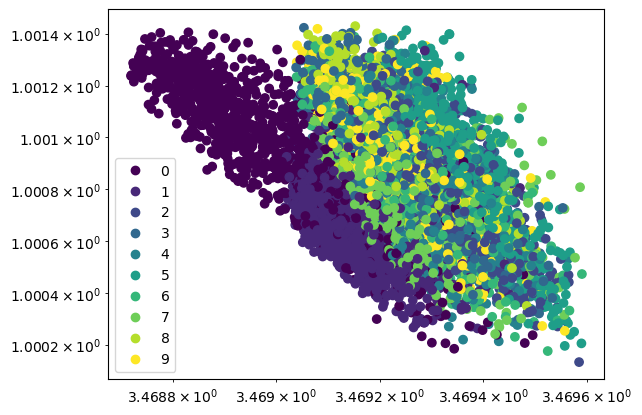

In [ ]:
scatter = plt.scatter(losses.detach().numpy(), evidences.detach().numpy(), c=labels_batch, alpha=1)
plt.yscale('log')
plt.xscale('log')
plt.legend(*scatter.legend_elements())

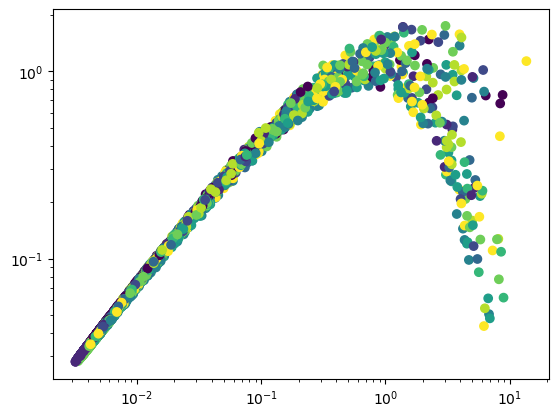

In [ ]:
plt.scatter(losses, entropies, c=labels_batch)
plt.yscale('log')
plt.xscale('log')

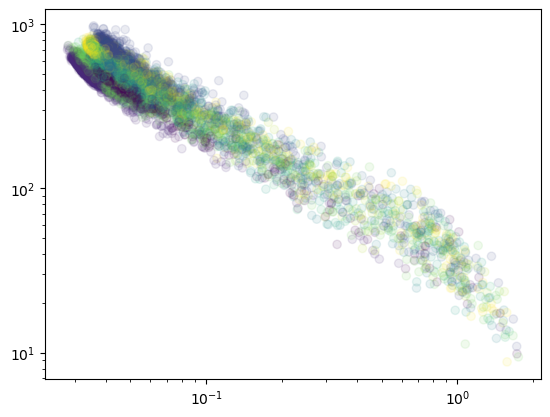

In [ ]:
plt.scatter(entropies, evidences, c=labels_batch, alpha=.1)
plt.yscale('log')
plt.xscale('log')

In [ ]:
true_alphas

tensor([[443.8360],
        [624.0986],
        [723.0762],
        ...,
        [544.6868],
        [273.7161],
        [581.1541]])

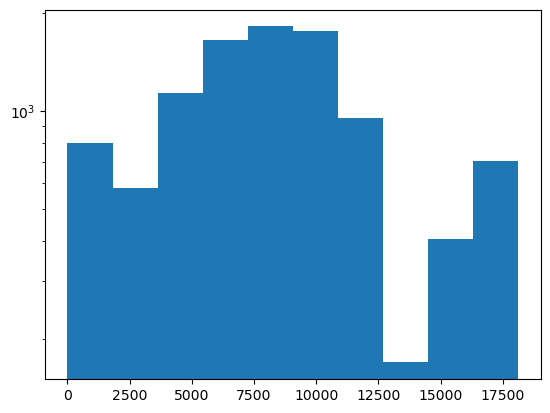

In [ ]:
plt.hist((true_alphas).view(-1).cpu().detach().numpy())
plt.yscale('log')

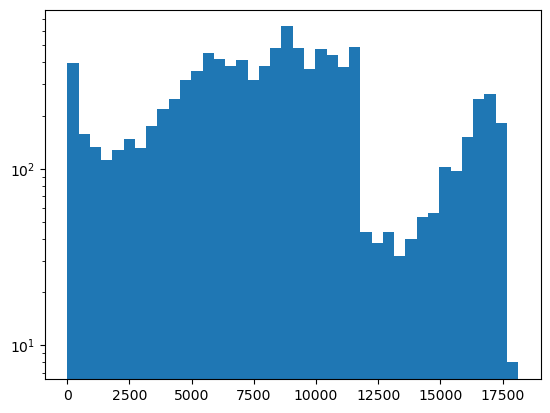

In [ ]:
plt.hist(true_alphas.view(-1).cpu().detach().numpy(), bins=40)
plt.yscale('log')

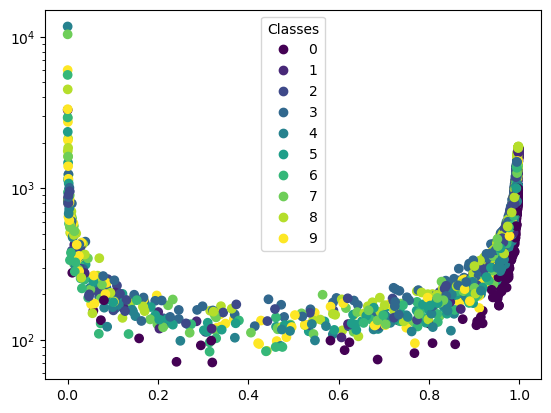

In [ ]:

scatter = plt.scatter((true_alphas/(true_alphas+true_betas)).view(-1).cpu().detach().numpy(),(true_alphas+true_betas).view(-1).cpu().detach().numpy(), c=labels_batch.numpy())
plt.yscale('log')
plt.legend(*scatter.legend_elements(), title="Classes")

In [ ]:
labels_batch[((true_alphas>400)*( (true_alphas/(true_alphas+true_betas))<.8)*(.2<(true_alphas/(true_alphas+true_betas)))).view(-1)]

tensor([], dtype=torch.int64)

In [ ]:
labels_batch[((true_alphas<100)*((true_alphas/(true_alphas+true_betas))<.8)*(.2<(true_alphas/(true_alphas+true_betas)))).view(-1)]

tensor([3, 7, 7, 5, 3, 3, 9, 0, 6, 9, 2, 2, 7, 3, 2, 5, 1, 9, 3, 4, 5, 2, 9, 8,
        5, 7, 5, 9, 8, 8, 4, 3, 4, 2, 3, 9, 5, 5, 7, 4, 8, 7, 3, 9, 6, 2, 2, 2,
        5, 5, 8, 8, 8, 2, 2, 5, 8, 4, 8, 6, 4, 5, 3, 5, 2, 9, 7, 5, 5, 7, 2, 2,
        0, 9, 6, 2, 1, 6, 7, 4, 7, 3, 9, 3, 7, 8, 8, 6, 5, 8, 8, 3, 8, 9, 7, 9,
        5, 2, 4, 3, 4, 7, 4, 8, 5, 9, 3, 7, 9, 3, 3, 8, 5, 5, 4, 4, 7, 6, 6, 7,
        8, 2, 3, 9, 8, 9, 7, 7, 6, 3, 6, 9, 3, 5, 3, 5, 2, 6, 9, 1, 7, 6, 8, 7,
        5, 7, 5, 7, 5, 3, 8, 5, 2, 2, 0, 2, 8, 9, 4, 7, 0, 5, 7, 5, 3, 2, 5, 3,
        4, 8, 2, 9, 4, 2, 9, 5, 0, 9, 2, 1, 4, 6, 7, 3, 3, 9])

In [ ]:
a,b =model(torch.randn(1,784).to(device))

In [ ]:
a/(a+b)

tensor([[9.5481e-01, 2.9279e-03, 9.8478e-01, 9.9282e-01, 1.8893e-01, 8.7521e-02,
         8.6043e-04, 9.6548e-01, 7.5512e-01, 1.2076e-02]],
       grad_fn=<DivBackward0>)

In [ ]:
a+b

tensor([[ 1.3016,  0.6483,  0.7193,  0.3592,  7.6514,  1.8314, 12.3111,  0.8062,
          3.3017,  0.5943]], grad_fn=<AddBackward0>)

In [ ]:
labels_batch.numpy()

array([5, 8, 3, ..., 6, 0, 9])

In [ ]:
(alphas/(alphas+betas)).sum(axis=1).var()**.5

tensor(0.0836, grad_fn=<PowBackward0>)

(array([ 5914.,  3482.,   398.,   400.,  1142., 37007., 39177.,  6715.,
         3977.,  1788.]),
 array([-0.9655295 ,  0.34486392,  1.65525734,  2.9656508 ,  4.27604437,
         5.5864377 ,  6.89683104,  8.20722485,  9.51761818, 10.82801151,
        12.13840485]),
 <BarContainer object of 10 artists>)

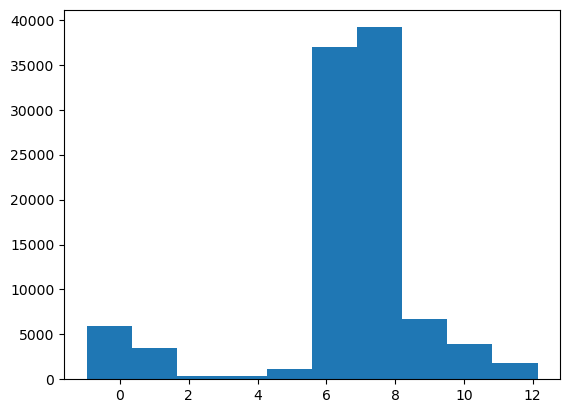

In [ ]:
plt.hist(np.log(betas.cpu().detach().numpy().flatten()))

In [ ]:
true_probs = true_alphas/(true_alphas+true_betas)

In [ ]:
probs = alphas/(alphas+betas)
evidence = alphas+betas

In [ ]:
losses = torch.digamma(alphas+betas).sum(axis=1) - torch.digamma(betas).sum(axis=1)+torch.digamma(true_betas).flatten()-torch.digamma(true_alphas).flatten()

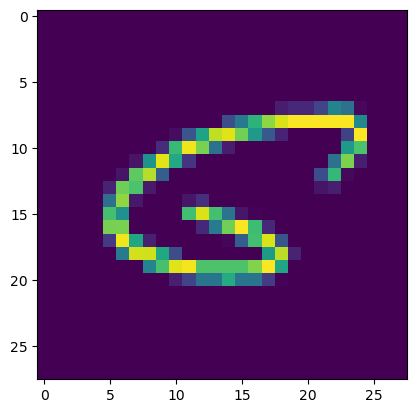

In [ ]:
plt.imshow(images[losses.argmax()].view(28,28))
plt.show()

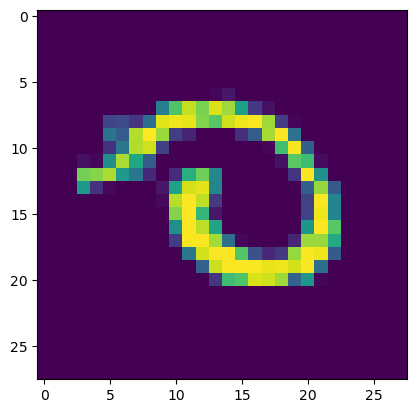

tensor(0)
tensor([0.0094, 0.0075, 0.1283, 0.3541, 0.0124, 0.0188, 0.0267, 0.0105, 0.2423,
        0.1899])
tensor(1.2977)


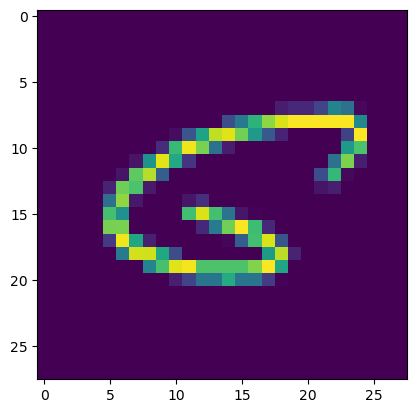

tensor(6)
tensor([0.0073, 0.0060, 0.0028, 0.0176, 0.0018, 0.8696, 0.0078, 0.0037, 0.0696,
        0.0138])
tensor(3.8510)


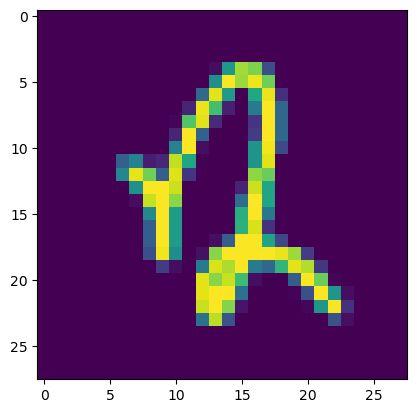

tensor(2)
tensor([0.0242, 0.0160, 0.0145, 0.0022, 0.6467, 0.0097, 0.0791, 0.0227, 0.0322,
        0.1529])
tensor(2.7549)


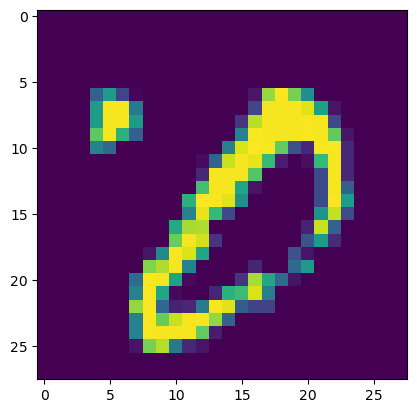

tensor(0)
tensor([0.0220, 0.0778, 0.0303, 0.3887, 0.0041, 0.0033, 0.0035, 0.0105, 0.4452,
        0.0147])
tensor(1.8726)


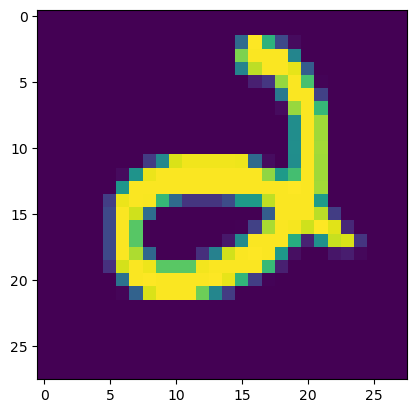

tensor(2)
tensor([0.0364, 0.0369, 0.0215, 0.3155, 0.0372, 0.0363, 0.4945, 0.0039, 0.0044,
        0.0134])
tensor(1.9174)


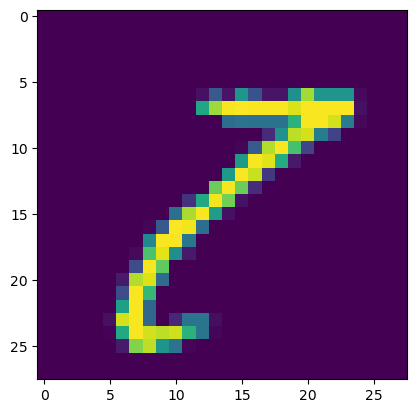

tensor(7)
tensor([0.0222, 0.0308, 0.0158, 0.2457, 0.0036, 0.0171, 0.0011, 0.0220, 0.6166,
        0.0251])
tensor(1.9399)


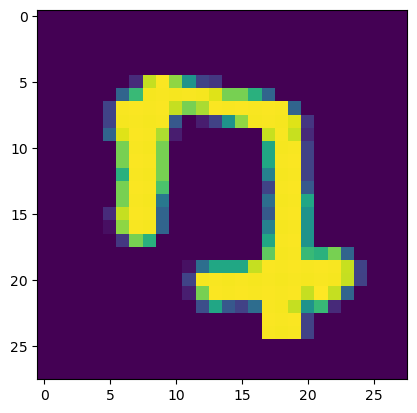

tensor(7)
tensor([0.3467, 0.0169, 0.1466, 0.0334, 0.0495, 0.0380, 0.0738, 0.0526, 0.1092,
        0.1333])
tensor(0.9099)


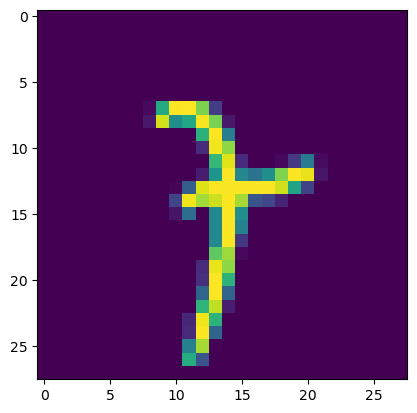

tensor(7)
tensor([0.0109, 0.0806, 0.0074, 0.0293, 0.0247, 0.0174, 0.0109, 0.0278, 0.6968,
        0.0943])
tensor(1.8925)


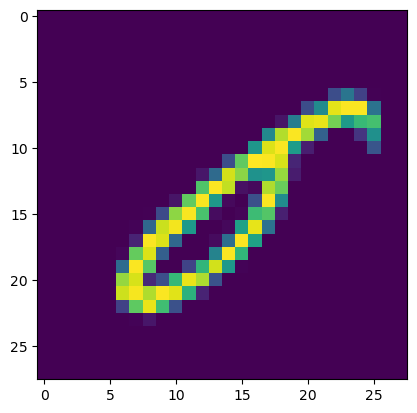

tensor(0)
tensor([0.0489, 0.0671, 0.0928, 0.0306, 0.0362, 0.2019, 0.0686, 0.0038, 0.4412,
        0.0089])
tensor(1.1294)


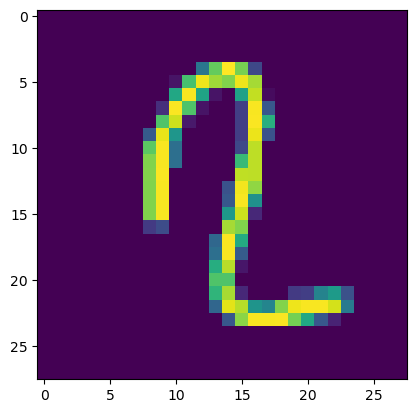

tensor(2)
tensor([0.0072, 0.0304, 0.0139, 0.0040, 0.0129, 0.0113, 0.0074, 0.0034, 0.8695,
        0.0400])
tensor(5.4287)


In [ ]:
for idx in losses.topk(10)[1]:
    image = images[idx].view(28,28)
    label = labels_batch[idx]
    plt.imshow(image)
    plt.show()
    print(label)
    print(probs[idx])
    print(evidences[idx])